In [319]:
from IPython.display import HTML
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Capston Project: Analytic Report & Research Proposal

## Evolution of GPD and Household Electricy Consumption 2000-2014

In [320]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
import itertools
%matplotlib inline

In [321]:
w = pd.read_csv('https://raw.githubusercontent.com/borja876/Thinkful-DataScience-Borja/master/Electricity%20Consumption.csv')
x = pd.read_csv('https://raw.githubusercontent.com/borja876/Thinkful-DataScience-Borja/master/GDP%20current%20prices.csv')
y = pd.read_csv('https://raw.githubusercontent.com/borja876/Thinkful-DataScience-Borja/master/Population.csv')

In [322]:
df = pd.DataFrame(w)
df1 = pd.DataFrame(x)
df2 = pd.DataFrame(y)

# Data sets description

The purpose of this report is to analyze the evolution of the household electricity market and GDP per continent in the period 2000-2014. This will show how different economic cycles have affected both variables and the potential correlation between them. Furthermore, in a per continent basis, the both variables will be scrutinized to depict the similarities and differences between continents that will show the relationship between them. Three data sets have been imported from United Nations (from now onwards UN) database. The data sets contain global information for the time span 2000-2014 regarding:

1. Electricity consumption for the household market (GhW). In this dataset, the UN has estimated values for some countries (ex-colonies of the UK) based on their April-March consumption. This estimation has been done up until 2004 yearly electricity consumption was standardized following the natural year and not the fiscal year. Electricity consumption in Iraq in 2014 has a null value, as it was not reported due to the war that started in 2015.

2. GDP per country in current USD. From all the data sets available, measuring GDP the one measuring it in current USD has been chosen to avoid the impact of the different base years across countries when calculating the base of the deflation year and to avoid the use of different exchange rates across countries during the time span under analysis.

3. Population. In this case, the population has been converted into (Thousands) as a unit to make the standardized GDP and electricity consumption significant. This variable shows the net population at the end of the year considering births, deaths and declared migration.

The three of them are significant because, although different data sets containing this information exist, only this institution (UN) gathers them. They are consistent in terms of the methods used to gather this information and credible due to the institution that is providing them. The three variables can be compared against each other reducing the bias that may exist in the data due to different data gathering technics used across countries.

Electricity consumption and GDP are two metrics that measure the wealth and wellbeing of a country. Its evolution during years can not only show where economy has experienced a slowdown and lose of welfare.

The chosen time span neutralizes the effect of the disappearance of the USSR which reduces the distortion of the obtained results. Furthermore, the evolution of these two variables before the year 2000 has not representative when predicting the future evolution of wealth and wellbeing of a country/continent or/and its economic slowdown. The main reason being that the way in which the information is gathered in both cases has changed at a macroeconomic level and base years have been adjusted in all countries to the year 2000.

Both variables, Electricity and GDP, have been analyzed after standardizing them considering the Population as the common factor. Additionally, they have been rescaled to kWh (electricity consumption) and (Million USD) to make them comparable. Household electricity consumption per individual and GDP per individual at current prices are better proxies of the welfare of the country and scaling issues disappear.

In [323]:
#Cleanse Data Frame Electricity Consumption:
#Delete rows without countries, rename columns and take out those that are not used
#Zeros are identified to see their potential impact on the data set and further results
dfa= df[:3206]
dfb= dfa.rename(columns={'Country or Area': 'Country', 'Quantity': 'Household Consumption (GWh)'})
dfc = dfb.drop(["Quantity Footnotes", "Unit", "Commodity - Transaction"], axis=1)
dfc['Year'] = dfc['Year'].astype(int)
#dfc.loc[dfc['Household Consumption (GWh)'] == 0]

In [324]:
#Cleanse Data Frame GDP Current Prices (USD):
#Cleanse Data Frame Electricity Consumption:
#Delete rows without countries, rename columns and take out those that are not used
#Zeros are identified to see their potential impact on the data set and further results
dfd= df1[:3322]
dfe= dfd.rename(columns={'Country or Area': 'Country', 'Value': 'GDP Current Prices (USD)'})
dfg = dfe.drop('Value Footnotes', axis=1)
dfg['Year'] = dfg['Year'].astype(int)
#dfg.loc[dfg['GDP Current Prices (USD)'] == 0]

In [325]:
#Cleanse Data Frame Population:
#Take out rows without countries
#Rename columns
#Clean columns taking out those that are not used
dfh= df2[:3522]
dfi= dfh.rename(columns={'Country or Area': 'Country', 'Value': 'Population'})
dfj = dfi.drop('Value Footnotes', axis=1)
dfj['Year'] = dfj['Year'].astype(int)
#dfj.loc[dfj['Population'] == 0]

In [326]:
#Merge data into a single dataset
#Cleanse new dataset
result = dfc.merge(dfg, left_on=["Country","Year"], right_on=["Country","Year"], how='outer')
result = result.merge(dfj, left_on=["Country","Year"], right_on=["Country","Year"], how='outer')
result = result.dropna()

#Rescale & rename variables in the new data set to GDP Current Prices (Million USD) & Population (Thousands)
result['GDP Current Prices (Million USD)']=result['GDP Current Prices (USD)']/1000000
result['Population (Thousands)']=result['Population']/1000

#Drop redundant columns after merging the data sets
result = result.drop('GDP Current Prices (USD)',1)
result = result.drop('Population',1)
result= result.rename(columns={'GDP Current Prices (USD)': 'GDP Current Prices (Million USD)', 'Population': 'Population (Thousands)'})

#Use population as a common ground to standardise GDP and household consumption to standardise both variables
result['Standard GDP Current Prices (USD)'] =(result['GDP Current Prices (Million USD)']*1000)/result['Population (Thousands)']
result['Standard Household Consumption (kWh)'] = (result['Household Consumption (GWh)']*1000)/result['Population (Thousands)']

A list of countries per continent has been imported from a different source (https://gist.github.com/pamelafox/986163). The use of this list aims to group by continent the information provided by the UN at a country level. This has risen additional difficulties due to the use different names between sources for several countries, for example: Russian Federation vs. Russia, Netherlands vs. The Netherlands, etc. Moreover, some countries have been identified in the original data set that are not included in the original list. This have been added to the list for the completeness. The aim of this addition is to have all continents accurately represented. America has been split into North and South America to have a detailed view of the evolution of both regions independently and to avoid distortion. The final continents used are:

1. Africa
2. Oceania
3. North America
4. South America
5. Europe
6. Asia

In [327]:
#Import list of countries per continent from external data set and clean the columns that will not be used.
countries = pd.read_json('https://raw.githubusercontent.com/borja876/Thinkful-DataScience-Borja/master/countries.txt')
countries =countries.drop (['capital','code','timezones'],1)

#Merge both data sets for have a complete working data set
result = result.merge(countries, left_on=["Country"], right_on=["name"], how='inner')
result = result.drop('name',1)
result = result.rename(columns={'continent': 'Continent'})

After checking that all countries considered by the UN are captured in the eternal list of countries used to group them by continent the final data set is created. The following table shows the first five rows of the final data set that will be used for the purpose of this report:

In [328]:
result.head()

,Country,Year,Household Consumption (GWh),GDP Current Prices (Million USD),Population (Thousands),Standard GDP Current Prices (USD),Standard Household Consumption (kWh),Continent
0,Afghanistan,2014,2204.9,20050.189882,31627.506,633.947864,69.714634,Asia
1,Afghanistan,2013,1633.5,20046.334304,30682.500,653.347488,53.238817,Asia
2,Afghanistan,2012,1922.0,20536.542737,29726.803,690.842629,64.655456,Asia
3,Afghanistan,2011,1145.0,17930.239400,28809.167,622.379654,39.744294,Asia
4,Afghanistan,2010,1387.0,15936.800636,27962.207,569.940729,49.602665,Asia


The following summary statistics have been conducted. In the table below, it can be seen the difference between extreme values for all variables, ranging from zero/tens to millions for electricity consumption and GDP. Once standardized variances continue to be high. This recommends the use of the median instead of the mean to avoid the effect of these extreme values. These extreme values come from United States (North America) which is equivalent to the whole Europe and Iraq (min) as zero for 2014.
The values of Skewness and Kurtosis show that variables cannot be following a normal distribution.

In [329]:
summary = result.describe().astype(int)
summary.drop('Year',1)
v = result.var()
v1 = pd.DataFrame(v, columns=['Var'])
w=result.skew()
w1 = pd.DataFrame(w, columns=['Skew'])
ww=result.kurt()
ww1 = pd.DataFrame(ww, columns=['kurt'])
df55 = v1.assign(Skew=w1.values, Kurt=ww1.values)
df56=df55.transpose()
frames = [summary, df56]
summaryb = pd.concat(frames).drop('Year',1)
summaryb

,Household Consumption (GWh),GDP Current Prices (Million USD),Population (Thousands),Standard GDP Current Prices (USD),Standard Household Consumption (kWh)
count,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03
mean,2.602300e+04,3.260570e+05,3.744600e+04,1.285000e+04,9.970000e+02
std,1.155270e+05,1.301789e+06,1.430070e+05,1.853300e+04,1.323000e+03
min,0.000000e+00,1.300000e+01,9.000000e+00,1.060000e+02,0.000000e+00
25%,2.720000e+02,4.350000e+03,1.368000e+03,1.140000e+03,1.430000e+02
50%,2.406000e+03,1.934400e+04,7.144000e+03,4.429000e+03,4.990000e+02
75%,1.257800e+04,1.372760e+05,2.112000e+04,1.591200e+04,1.363000e+03
max,1.445712e+06,1.734807e+07,1.364270e+06,1.166120e+05,8.475000e+03
Var,1.334670e+10,1.694657e+12,2.045109e+10,3.435078e+08,1.752481e+06
Kurt,1.064086e+02,8.483685e+01,6.319272e+01,5.364767e+00,7.510758e+00


A t test has been conducted showing that the difference in means between both the standard electricity consumption and the standard GDP are truly because the populations are different and not due to variability. As both original variables are representing different populations, the standardised ones follow the same principle (as it can deducted from the obtained p values).

In [330]:
print(ttest_ind(result['Household Consumption (GWh)'], result['GDP Current Prices (Million USD)'], equal_var=False))
print(ttest_ind(result['Standard Household Consumption (kWh)'], result['Standard GDP Current Prices (USD)'], equal_var=False))

Ttest_indResult(statistic=-11.256236797599108, pvalue=1.0845783819097141e-28)
Ttest_indResult(statistic=-31.277206681394773, pvalue=9.7997898470784634e-181)


A closer look at each of the variables confirms what was anticipated by the Skewness and Kurtosis coefficients. When each of the variables is compared against a normal distribution, none of them follow this kind of distribution.

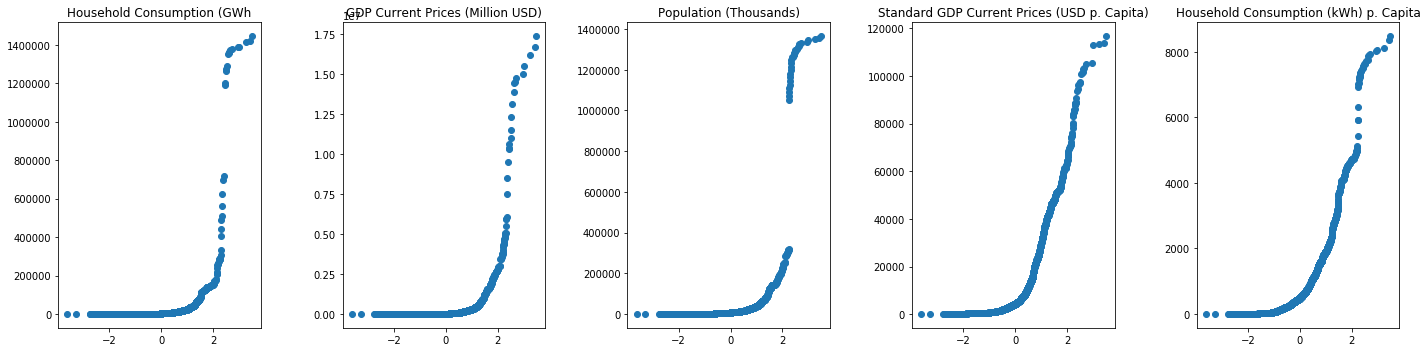

In [331]:
# Making two variables.
norm = np.random.normal(0, 1, 2404)
norm.sort()
a = result.sort_values('Household Consumption (GWh)',ascending=True)
b = result.sort_values('GDP Current Prices (Million USD)',ascending=True)
c = result.sort_values('Population (Thousands)',ascending=True)
d = result.sort_values('Standard GDP Current Prices (USD)',ascending=True)
e = result.sort_values('Standard Household Consumption (kWh)',ascending=True)

#Checking that variables are not normally distributed
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.plot(norm,a['Household Consumption (GWh)'], "o") 
plt.title('Household Consumption (GWh')

plt.subplot(1, 5, 2)
plt.plot(norm,b['GDP Current Prices (Million USD)'], "o") 
plt.title('GDP Current Prices (Million USD)')

plt.subplot(1, 5, 3)
plt.plot(norm,c['Population (Thousands)'], "o") 
plt.title('Population (Thousands)')

plt.subplot(1, 5, 4)
plt.plot(norm,d['Standard GDP Current Prices (USD)'], "o") 
plt.title('Standard GDP Current Prices (USD p. Capita)')

plt.subplot(1, 5, 5)
plt.plot(norm,e['Standard Household Consumption (kWh)'], "o") 
plt.title('Household Consumption (kWh) p. Capita')

plt.tight_layout()
plt.show()

From the histograms below, it can be seen that the distribution of values is asymmetric, having a high concentration of values in the lower end and a long tail which shows the dispersion of values (with very low frequencies of occurrence). The standardized variables follow the same pattern in terms of frequency of occurrence between lower and higher values.

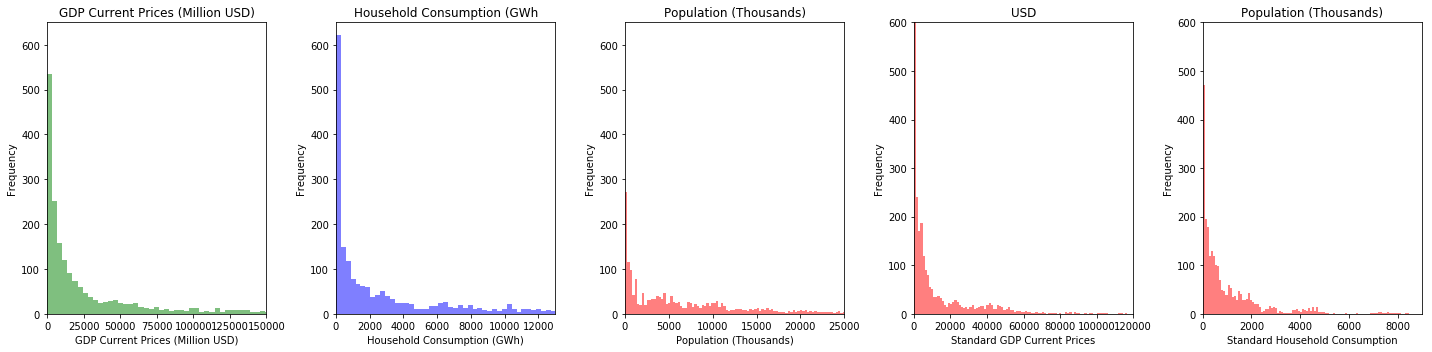

In [332]:
#Histograms
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.xlabel("GDP Current Prices (Million USD)")
plt.ylabel("Frequency")
plt.hist(result['GDP Current Prices (Million USD)'], bins= 5000 ,facecolor='green', alpha=0.5)
plt.axis([0, 150000, 0, 650])
plt.title('GDP Current Prices (Million USD)')

plt.subplot(1, 5, 2)
plt.xlabel("Household Consumption (GWh)")
plt.ylabel("Frequency")
plt.hist(result['Household Consumption (GWh)'], bins=5000 ,facecolor='blue', alpha=0.5)
plt.axis([0, 13000, 0, 650])
plt.title('Household Consumption (GWh')

plt.subplot(1, 5, 3)
plt.xlabel("Population (Thousands)")
plt.ylabel("Frequency")
plt.hist(result['Population (Thousands)'], bins=5000 ,facecolor='red', alpha=0.5)
plt.axis([0, 25000, 0, 650])
plt.title('Population (Thousands)')

plt.subplot(1, 5, 4)
plt.xlabel("Standard GDP Current Prices")
plt.ylabel("Frequency")
plt.hist(result['Standard GDP Current Prices (USD)'], bins=100 ,facecolor='red', alpha=0.5)
plt.axis([0, 120000, 0, 600])
plt.title('USD')

plt.subplot(1, 5, 5)
plt.xlabel("Standard Household Consumption")
plt.ylabel("Frequency")
plt.hist(result['Standard Household Consumption (kWh)'], bins=100 ,facecolor='red', alpha=0.5)
plt.axis([0, 9000, 0, 600])
plt.title('Population (Thousands)')

plt.tight_layout()
plt.show()

# Question 1: Is there a relationship between GDP and Household 

# consumption? Is it the same across continents?

When comparing the data sets without grouping the data into continents, the correlation matrix below shows that there is no correlation between years GDP and Electricity consumption, hence there is no inflation effect on the variables. There is a strnger correlation between the standard GDP and the years due to the impact of population.

The table below highlights the positive and strong relationship between electricity consumption and GDP. Furthermore, it evidences the relationship between our standardized variables: both vary in the same direction but at a lower rate due to the impact in the variable “Population” used to standardize them. It also evidences the positive relationship between population and electricity consumption. As expected, it shows that only half of the increase is due to an increase in population leaving the other half unexplained.

In [333]:
#Calculate the correlation matrix
result.corr()

,Year,Household Consumption (GWh),GDP Current Prices (Million USD),Population (Thousands),Standard GDP Current Prices (USD),Standard Household Consumption (kWh)
Year,1.000000,0.026306,0.069377,0.013221,0.160749,0.019390
Household Consumption (GWh),0.026306,1.000000,0.968013,0.415895,0.201296,0.262330
GDP Current Prices (Million USD),0.069377,0.968013,1.000000,0.403854,0.258789,0.255487
Population (Thousands),0.013221,0.415895,0.403854,1.000000,-0.058557,-0.059805
Standard GDP Current Prices (USD),0.160749,0.201296,0.258789,-0.058557,1.000000,0.730365
Standard Household Consumption (kWh),0.019390,0.262330,0.255487,-0.059805,0.730365,1.000000


For a more granular inspection of the data, median from the standardized variables will be used based on the initial findings regarding the disparity of values in the original data sets. Furthermore, and due to the representativeness of the standardized values, analysis per continent will be based on them, only using the unstandardized values when additional conclusions can be obtained.

The following charts show the values per continent of the standardized variables. The table shows that there is a significant difference in values between continents, both in the standard household consumption and in the GDP.

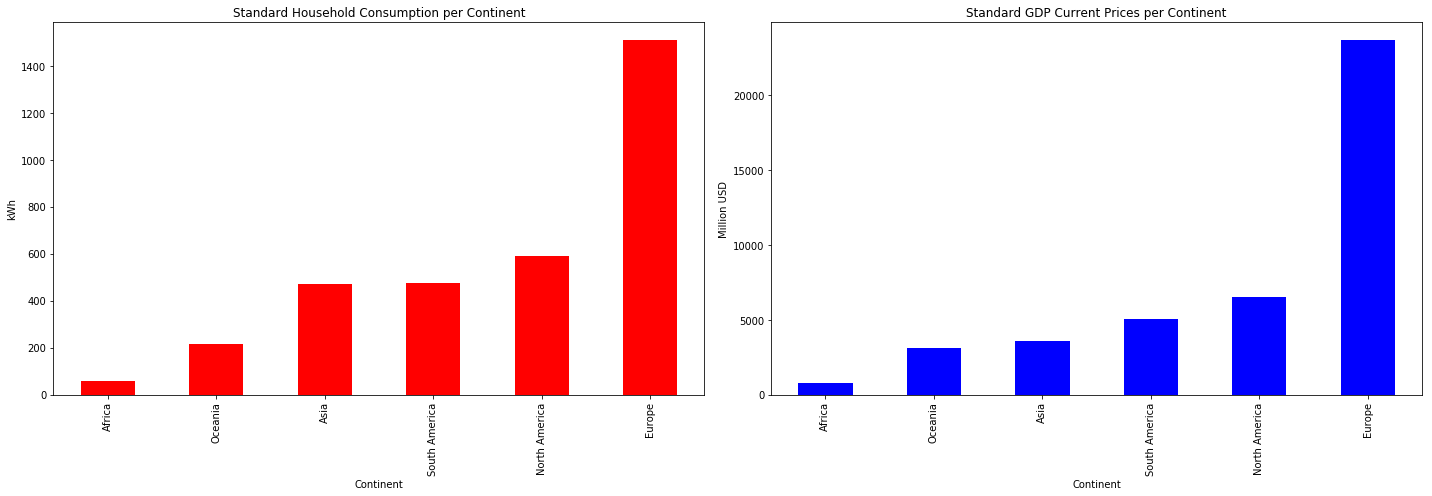

In [334]:
#Plot standard household consumption and standard GDP grouped by continents

result2=result.groupby(['Continent']).median()
result3 = result2.sort_values(['Standard Household Consumption (kWh)'])

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)

result3['Standard Household Consumption (kWh)'].plot(kind='bar', color='red')
plt.ylabel('kWh')
plt.title('Standard Household Consumption per Continent')

plt.subplot(1, 2, 2)
result3['Standard GDP Current Prices (USD)'].plot(kind='bar', color='blue')
plt.ylabel('Million USD')
plt.title('Standard GDP Current Prices per Continent')

plt.tight_layout()
plt.show()

The following box plot shows the summary statistics describing the values per continent of each of the variables. It can be appreciated that variance is lower in the case of the standard household consumption compared to the standard GDP. The min value in terms of standard GDP is much lower thant the percentil 25 while in the case of the electricity consumption values are more compact.

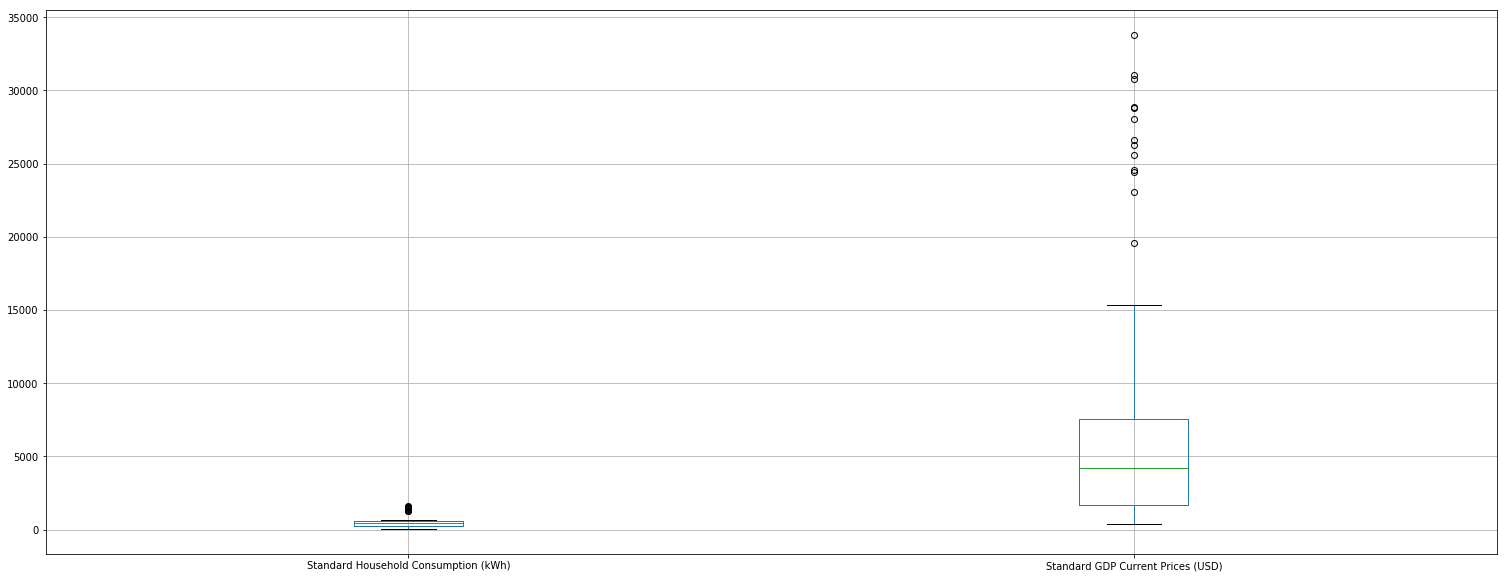

In [335]:
#Box-plot
result1=result.groupby(['Continent','Year']).median()
result1[['Standard Household Consumption (kWh)','Standard GDP Current Prices (USD)']].boxplot(figsize=(26, 10))

When analyzing the correlation between standard household consumption and standard GDP, North & South America and Asia show a higher correlation than the rest of the continents. In the case of Europe, values are more scattered in the higher end of the graph due to a higher standard GDP. It can be concluded that the correlation between both variables although exists in all continents, vaires varies between continents in terms of its strength.

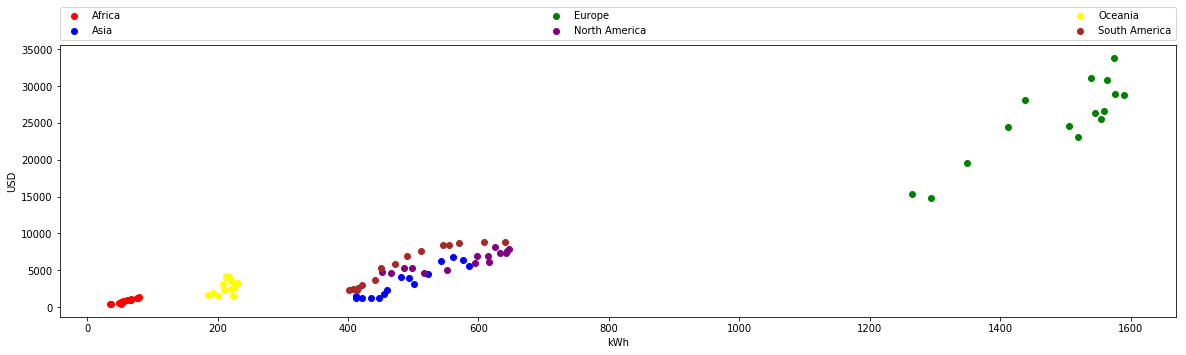

In [336]:
#Scatter plot showing the correlation between standardised values
C = result1.index.levels[0]
colors = itertools.cycle(["r", "b", "g", 'purple','yellow','brown'])

plt.figure(figsize=(20, 5))

for cont in C :
    graph = result1.loc[cont]
    plt.scatter(x=graph['Standard Household Consumption (kWh)'], y=graph['Standard GDP Current Prices (USD)'], color = next(colors), marker= 'o', label = cont)
plt.ylabel('USD')
plt.xlabel('kWh')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

plt.show()

Further investigation depicts how the relationship of each of the raw variables (Household Consumption (GWh) and GDP) that form each of the standard variables differ. Additionally, within continents, it can be seen that the relationship between both consumption and GDP vs population behave in a similar way.
Especially notorious is the case of Africa, that shows how both GDP and electricity consumption grow with population. In this case although it could be infer due to the characteristics of its economy that the correlation between both is closer to 1, it can be seen how the slope is steeper than the unit due to the contribution of other factors to both variables.

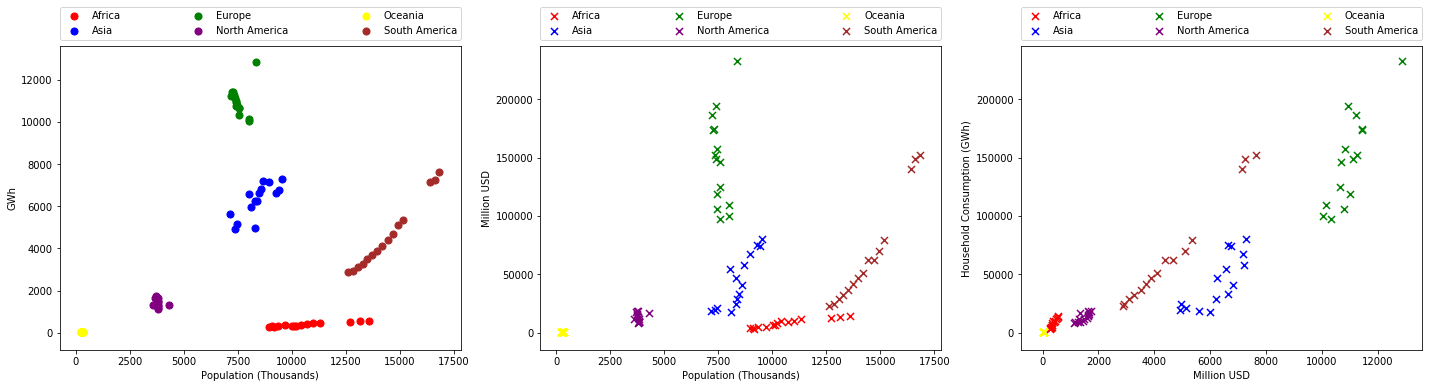

In [337]:
#Plot correlation between unstandardised variables to undertand the source of correlation
C = result1.index.levels[0]
colors = itertools.cycle(["r", "b", "g", 'purple','yellow','brown'])

plt.figure(figsize=(20, 5))


plt.subplot(1, 3, 1)
for cont in C :
    graph = result1.loc[cont]
    plt.scatter(x=graph['Population (Thousands)'], y=graph['Household Consumption (GWh)'], color = next(colors), marker = 'o', s = 50, label=cont)
plt.ylabel('GWh')
plt.xlabel('Population (Thousands)')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

#plt.ylim([20000, 160000])
#plt.title('Electricity consumption')
#plt.show()

plt.subplot(1, 3, 2)
for cont in C :
    graph = result1.loc[cont]
    plt.scatter(x=graph['Population (Thousands)'], y=graph['GDP Current Prices (Million USD)'], color = next(colors),marker = 'x', s = 50, label=cont)
plt.ylabel('Million USD')
plt.xlabel('Population (Thousands)')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

plt.subplot(1, 3, 3)
for cont in C :
    graph = result1.loc[cont]
    plt.scatter(x=graph['Household Consumption (GWh)'], y=graph['GDP Current Prices (Million USD)'], color = next(colors),marker = 'x', s = 50, label=cont)
plt.ylabel('Household Consumption (GWh)')
plt.xlabel('Million USD')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

plt.tight_layout()
plt.show()

As it can be seen from the graphs above, each continent follows a different pattern in terms of standard electricity consumption and standard GDP against population. Hence detailed analysis show how each continent behaves in a different way although initially, when considering global data, the relationship between both variables was high and positive.

# Question 2: How has the economic welfare of countries evolved from the year 2000?

From the graphs below it can be seen that standard electricity consumption and standard GDP is higher in Europe than in the rest of the continents. In all cases both variables experience an increase during the period and except for Europe the increase seems to be smoother in the rest of the continents. 

From an electricity consumption perspective, the graph depicts how the economic downturns of 2008 affected the welfare of the population. It also shows how up until that year, when natural gas was considered an alternative cheaper solution for household heating systems, the population was relying on its use. The rest of the continents were more conservative in the use of electricity for household needs. It can be seen how there is a strong decrease in electricity consumption in 2002 and 2004 both in Asia and North America. The first change in slope can be seen in Asia in 2002 (due to the economic downturn that the country experienced that year). This decrease impacts North America in 2004 as part of its knock on effect. On the flipside, Europe slightly decreases its rate of increase but still increases the electricity consumption up until 2008. The economic Africa´s growth, in the lower-end is mainly due to the penetration of new electricity infrastructure during this period.

From a GDP perspective, the graph shows the deep impact that the 2008 economic downturn had in Europe. Although hiking up until then, the loss by 2014 was considerable in relative terms. For the rest of the continents, the 2002 economic downturn can be observed. It is worth mentioning the economic acceleration that Asia has experimented during the period. Starting at a lower point than Oceania, it grows surpassing Oceania after 2006 and continues to grow at a higher rate than the rest of the continents. A similar growth is driven by South America but for different reasons. In this case it is not mainly the growth of the GDP but the decrease in population due to the crisis experienced by Argentina at the beginning of the century.

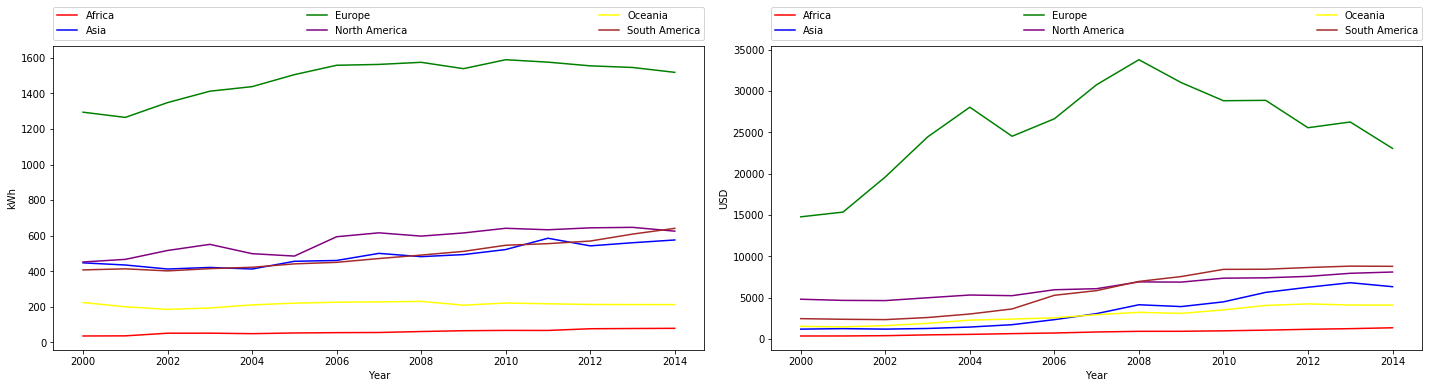

In [338]:
#Plot time series showing the evolution of the standardised variables

C = result1.index.levels[0]
colors = itertools.cycle(["r", "b", "g", 'purple','yellow','brown'])

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
for cont in C :
    graph = result1.loc[cont]
    plt.plot(graph.index, graph['Standard Household Consumption (kWh)'], color = next(colors), linestyle = "-", label = cont)
plt.ylabel('kWh')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

plt.subplot(1, 2, 2)
for cont in C :
    graph = result1.loc[cont]
    plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-", label = cont)
plt.ylabel('USD')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

plt.tight_layout()
plt.show()


# Question 3: What was the behavior of each continent during this period?

All six continents have increased their wealth during the period 2000-2014. Europe and America have more than doubled their GDP per capita while the rest of the continents have multiplied by 3 except for Asia that has multiplied its GDP by 7.  All continents show a flat or declining GDP during the period 2002-2004, being the case of Asia the most significant.

All except for Europe and South America have experienced a slight decrease in its GDP due to the economic crisis if compared to Europe. It can be seen that Europe was one of the continents that was experiencing higher growth but also higher decline due to the crisis. In the case of America, periods of growth and slowdown have been alternating every two years.

Europe has been the continent that has experienced the highest economic downturn during the period. Although it was one of the highest growing ones up until 2008, the economic downturn has significantly reduced the GDP per capita up until more than USD10,000.

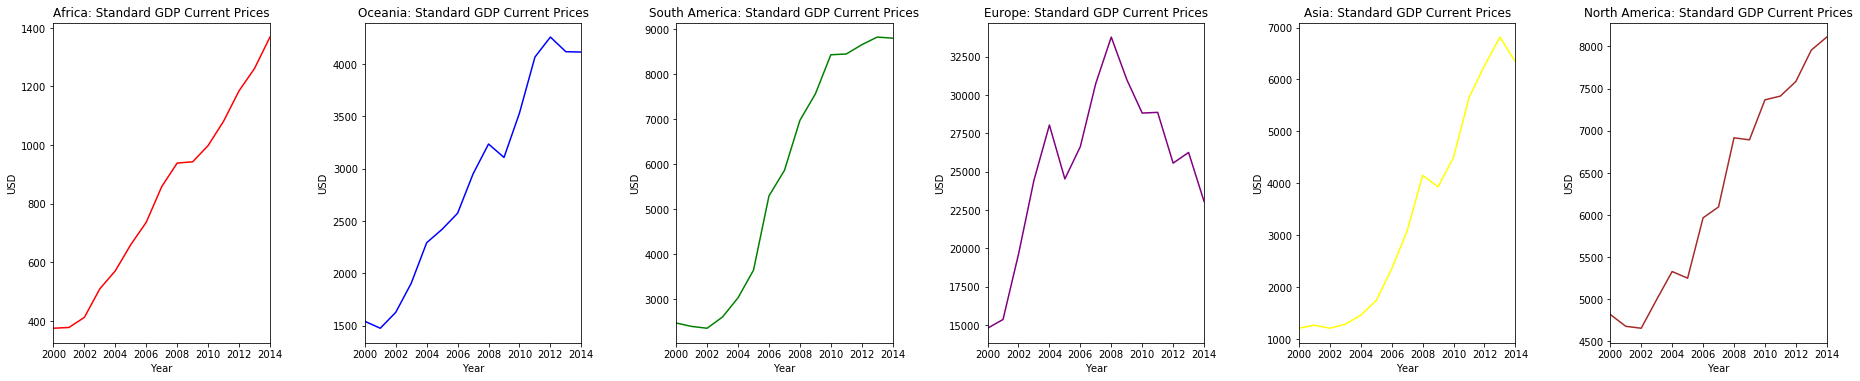

In [339]:
#Plot 6 graphs showing the evolution of standard GDP per continent
C = result1.index.levels[0]
colors = itertools.cycle(["r", "b", "g", 'purple','yellow','brown'])

plt.figure(figsize=(26, 10))

plt.subplot(2, 6, 1)

graph = result1.loc['Africa']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('Africa: Standard GDP Current Prices')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 2)

graph = result1.loc['Oceania']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('Oceania: Standard GDP Current Prices')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 3)

graph = result1.loc['South America']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('South America: Standard GDP Current Prices')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 4)

graph = result1.loc['Europe']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('Europe: Standard GDP Current Prices')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 5)
graph = result1.loc['Asia']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('Asia: Standard GDP Current Prices')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 6)
graph = result1.loc['North America']
plt.plot(graph.index, graph['Standard GDP Current Prices (USD)'], color = next(colors), linestyle = "-")
plt.ylabel('USD')
plt.xlabel('Year')
plt.title('North America: Standard GDP Current Prices')
plt.xlim([2000, 2014])
plt.tight_layout()
plt.show()


Electricity consumption per household decreases in all continents between 2002 ad 2004. This is due to two main reasons. The increase of electricity prices correlated to and oil prices basket at that time and the economic slowdown that took place in that period. Although it shows an increase in all six continents, the behavior during the period under analysis is significantly different:

In Africa, electricity consumption decreases in 2004 and steadily increases during the period. After 2004 every 2 years Africa experiences a contraction in consumption followed by an increase that compensates and surpasses in absolute terms the contraction. Compared to the rest of the continents it seems too have the steepest slope only comparable to South America. This can be mainly because of the penetration of electricity infrastructure in the continent and its low starting point in terms of standard electricity consumption.

In Australia there is a decrease in consumption in 2002 and after a continuous increase up unitl 2008, it stabilizes around the value achieve in 2014. This is mainly due to the environmental and demand management regulation introduced in the country in 2006 added to the economic downturn that affected Australia in 2008.
In South America, there is a steady increase in electricity consumption due to the emigration after the recession at the beginning of the century.

In North America and Europe, electricity consumption growth is similar to Europe. In both there is a decrease in 2002-2004 due to the economic downturn in the case of Europe and to the introduction of natural gas and regulation giving positive incentives to the use of it in heating systems. Additionally, in North America the deregulation of household production makes the impact in this country higher than in Europe. In both, the main responsible for the 2008 decrease in electricity consumption is the real estate crisis that affected Europe more than America but it had its consequences in both.

In Asia, electricity consumption has followed an increasing path during the period. After the 2002-2004 stagnation in terms of consumption, the increase experienced by this region has been uneven. It has followed a pattern of two years of growth and one year of decrease. During the growth periods, it has increased its household consumption roughly 100 kWh per capita. During the declining periods, consumption has fall one quarter of its increase. 

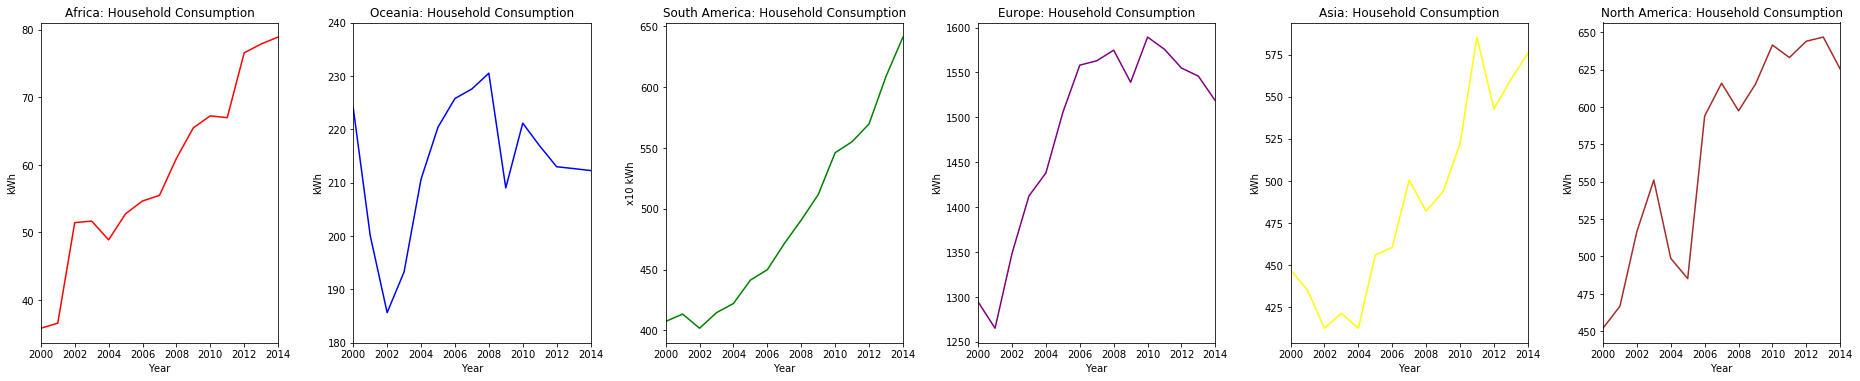

In [340]:
#Plot six graphs showing the evolution of standard electricity consumption per continent
C = result1.index.levels[0]
colors = itertools.cycle(["r", "b", "g", 'purple','yellow','brown'])

plt.figure(figsize=(26, 10))

plt.subplot(2, 6, 1)

graph = result1.loc['Africa']
plt.plot(graph.index, graph['Standard Household Consumption (kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('kWh')
plt.xlabel('Year')
plt.title('Africa: Household Consumption')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 2)

graph = result1.loc['Oceania']
plt.plot(graph.index, graph['Standard Household Consumption (kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('kWh')
plt.xlabel('Year')
plt.title('Oceania: Household Consumption')
plt.xlim([2000, 2014])
plt.ylim([180, 240])

plt.subplot(2, 6, 3)

graph = result1.loc['South America']
plt.plot(graph.index, graph['Standard Household Consumption (kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('x10 kWh')
plt.xlabel('Year')
plt.title('South America: Household Consumption')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 4)

graph = result1.loc['Europe']
plt.plot(graph.index, graph['Standard Household Consumption (kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('kWh')
plt.xlabel('Year')
plt.title('Europe: Household Consumption')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 5)
graph = result1.loc['Asia']
plt.plot(graph.index, graph['Standard Household Consumption (kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('kWh')
plt.xlabel('Year')
plt.title('Asia: Household Consumption')
plt.xlim([2000, 2014])

plt.subplot(2, 6, 6)
graph = result1.loc['North America']
plt.plot(graph.index, graph['Standard Household Consumption (kWh)'], color = next(colors), linestyle = "-")
plt.ylabel('kWh')
plt.xlabel('Year')
plt.title('North America: Household Consumption')
plt.xlim([2000, 2014])

plt.tight_layout()
plt.show()

# Next steps, further questions and tools to answer them

Although there is no consistent data available for 20014-2017, there are several questions to be analysed as next steps:

1. What has happened during this period in terms of economic and consumption growth? What is the impact of new demand management regulation introduced in each country and is there a true effect on consumption?

2. What would be the projection of the electricity consumption and economic growth for the different continents based on the previous years? How does it compare to the potential growth based on other factors?

3. Can countries be clustered in a different way and not only at a continent level based on its electricity consumption and GDP? Are there any other variables that could be used to measure their true wealth and social welfare?

4. Can we compare the electricity consumption across economic sectors with the electricity production by energy source? What are the trends and how does the future look like.

Question 1 could be solved by using forecasting and time series techniques while question 2 would require NLP to analyse non-quantitative information coming from the country to adjust the economic values obtained in the analysis.
Question 3/4 would required clustering techniques to see which kind of cluster is the best to gain a deeper understanding of the correlation between social welfare and electricity consumption. Additionlly, the analysis could be extended from household consumption but all intensive-electricity-consumption sectors/verticals. Maybe it could be clustered using the electricity source and then move into each of the buckets the electricity consumption and predict the future using machie learning (regression, etc).